In [211]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc
from typing import Tuple

## Variables

In [2]:
# reagent 1 name
name_sol1 = "BSA"
# reagent 1 starting contentration
initial_conc_sol1 = 266
# unit
unit_sol1 = "µM"


# reagent 2 name
name_sol2 = "PEG"
# reagent 2 starting concentration
initial_conc_sol2 = 10
# unit
unit_sol2 = "%"


# mixing ratio of the concentrations 0
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 3

# Number of wells per row(!) per concentrations
# usually equals 10
n_wells = 1

# How many hours did the experiment last?
hours_of_experiment = 17


# How many pictures where taken per hour per well?
images_per_hour = 1


# percental difference of img mean to all previous imgages. 
# value is similar to a sensivity-value
percental_threshold = 10 


# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
# around +-30 of the real value, best measured with something like imageJ/Fiji
diameter = 238 
minRadiusChamber = int((diameter/2)*0.7)
maxRadiusChamber = int((diameter/2)*1.3)


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
# best is to use only paths without any whitespace
#image_folder = "C:Users/DigitalStation/Documents/Universität Stuttgart/Institut für industrielle Bioverfahrenstechnik/1_Masterthesis/Experiments/20210804 First OFM Exp/Images"
# image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages"

image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\testimages2+"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages3"

# datatype of the images
extension = ".jpg"

In [ ]:
import PIL.Image
from datetime import datetime
import PIL.ExifTags
import dateutil.parser

img = PIL.Image.open(r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages3\c0_w0_s0t1c0x0-1007y0-1128.jpg")
exif_data = img._getexif()
exif = {
    PIL.ExifTags.TAGS[k]: v
    for k, v in img._getexif().items()
    if k in PIL.ExifTags.TAGS
}

date = exif['DateTimeOriginal']
print(date)

In [ ]:
import PIL.Image
from datetime import datetime
import PIL.ExifTags
import dateutil.parser


#print(type(yourdate))

import os
import re
import numpy as np

In [ ]:
%%timeit
def get_sorted_file_list(image_folder: str) -> list:
    files, times, concs, wells = [], [], [], []
    
    for file in os.listdir(image_folder):
        # 1. More robust, faster, but more specific
        c, w, _, t = re.search("c(\d+)_w(\d+)_s(\d+)t(\d+)", file).groups()

        # 2. Other way
        #c, w, _, t, *params = re.findall('[0-9]+', file)
        
        # Generate lists
        times.append(int(t))
        concs.append(int(c))
        wells.append(int(w))
        files.append(file)
        
    return [x for _, _, _, x in sorted(zip(concs, times, wells, files))]
    
get_sorted_file_list(image_folder)

## Programm

In [3]:
# Create all the necessary dicts and lists
image_list, image_names, data_well, well, concentration, time_resolution = pypc.create()

# Load images & convert to grayscale
pypc.images_to_list(image_list, image_names, image_folder, extension)
pypc.images_to_dict(hours_of_experiment, images_per_hour, number_of_diff_conc, n_wells, image_list, image_names,
                    time_resolution, concentration, well, data_well)

# Detect chamber, create & apply mask
pypc.chamber_detection_and_mask_creation(number_of_diff_conc, n_wells, time_resolution, minRadiusChamber, maxRadiusChamber)

# Detect LLPS
pypc.detect_LLPS(hours_of_experiment, images_per_hour, number_of_diff_conc, n_wells,
                 time_resolution, percental_threshold)

# Calculate c_crit
starting_concentrations = pypc.ccrit_calculation(initial_conc_sol1, initial_conc_sol2, initial_ratio,
                       hours_of_experiment, images_per_hour, number_of_diff_conc, n_wells, time_resolution)

# saves the image names where LLPS was detected and the calculated concentrations to a csv file
# .csv gets safed in the image folder
#pypc.save_results_to_csv(time_resolution, image_folder, number_of_diff_conc, n_wells, hours_of_experiment,
#                       images_per_hour, name_sol1, name_sol2, unit_sol1, unit_sol2)


Creating and sorting image list


100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 158.51it/s]


writing images into big dictionary


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 144.06it/s]


detect chambers and create masks


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.26s/it]

No chamber could be detected, please adjust radius
conc 2 well 1
LLPS detection



 14%|███████████▊                                                                       | 2/14 [00:01<00:06,  1.75it/s]

no droplet could be found in well t4_c1_w1
no droplet could be found in well t5_c1_w0


 29%|███████████████████████▋                                                           | 4/14 [00:02<00:05,  1.77it/s]

no droplet could be found in well t6_c1_w1


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:02<00:01,  3.70it/s]

no droplet could be found in well t8_c1_w1
no droplet could be found in well t10_c1_w1

 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:02<00:00,  5.04it/s]


no droplet could be found in well t12_c1_w1

 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:03<00:00,  6.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.09it/s]

no droplet could be found in well t15_c1_w1
calculation of the critical concentration



100%|███████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 17937.15it/s]


## quality control

In [ ]:
#5,0,0

# time to check
time_idx = 5

# concentration to check
conc_nr = 1

# well to check
well_nr = 0


# uncomment this to get some insight into image processing
pypc.quality_control(time_resolution, time_idx, conc_nr, well_nr, name_sol1, name_sol2,
                     unit_sol1, unit_sol2, starting_concentrations, time_resolution[0][conc_nr][well_nr]['circles'])

In [ ]:
# apply processing to image before circle detection (test)

temp = cv2.blur(time_resolution[t][conc_nr][well_nr]['masked image'].copy(), (2,2))
temp = 
final = temp.copy()

plt.imshow(final)


In [221]:
def outside_std_dev(derv: np.ndarray) -> np.ndarray:
    # Checks if value is outside the 1st std
    # if so, it sets the value to 1, all other values are zeros
    outside_std = np.zeros(len(derv))
   
    for idx, y in enumerate(derv):
        if (y > np.median(derv) + np.std(derv)) or (y < np.median(derv) - np.std(derv)):
            outside_std[idx] = 1
    
    return outside_std
            
    
def find_edges(outside_std: np.ndarray, search_length: int = 20) -> Tuple[int, int]:
    # set up array for the left side
    # made up of zeros with a the first element as a one, this is the desired pattern we look for
    searchval = np.zeros(search_length)
    searchval[0] = 1
    
    # array for the right side
    searchval_rev = searchval[::-1]

    N = len(searchval)
    # searches for all the ones in outside_std
    possibles = np.where(outside_std == searchval[0])[0]
    
    # outside_std = [0, 1, 0, 0, 1, 0, 0]
    # possibles = [1, 4]; index of possible solutions
    # check = outside_std[1:2]; full slice of possible solutions 

    solns = []
    for p in possibles:
        check = outside_std[p : p + N]
       
        # checking if full slice matches my desired pattern (which is defined by searchval)
        # gives you all the patterns that matches your searval
        if np.all(check == searchval):
            solns.append(p)
    
    # doing the same stuff for the right side
    possibles = np.where(outside_std == searchval_rev[0])[0]

    solns_rev = []
    for p in possibles:
        check = outside_std[p:p+N]
        if np.all(check == searchval_rev):
            solns_rev.append(p + search_length -1)
    
    left_edge, right_edge = solns, solns_rev
    print("poss. solutions left",solns)
    print("poss. solutions right", solns_rev)
    # selecting the first solution from the left side and last solution from the right side
    return left_edge[0], right_edge[-1], solns, solns_rev

In [216]:
outside_std = outside_std_dev(derv)
left_edge, right_edge = find_edges(outside_std, search_length=20)

<ipython-input-200-b4a26b95a7e2>:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(check == searchval):
<ipython-input-200-b4a26b95a7e2>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(check == searchval_rev):


97.7 ms ± 9.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<ipython-input-221-3ec2c4a5a3db>:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(check == searchval):
<ipython-input-221-3ec2c4a5a3db>:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(check == searchval_rev):


poss. solutions left [19, 170]
poss. solutions right [165, 245]
446 250 118


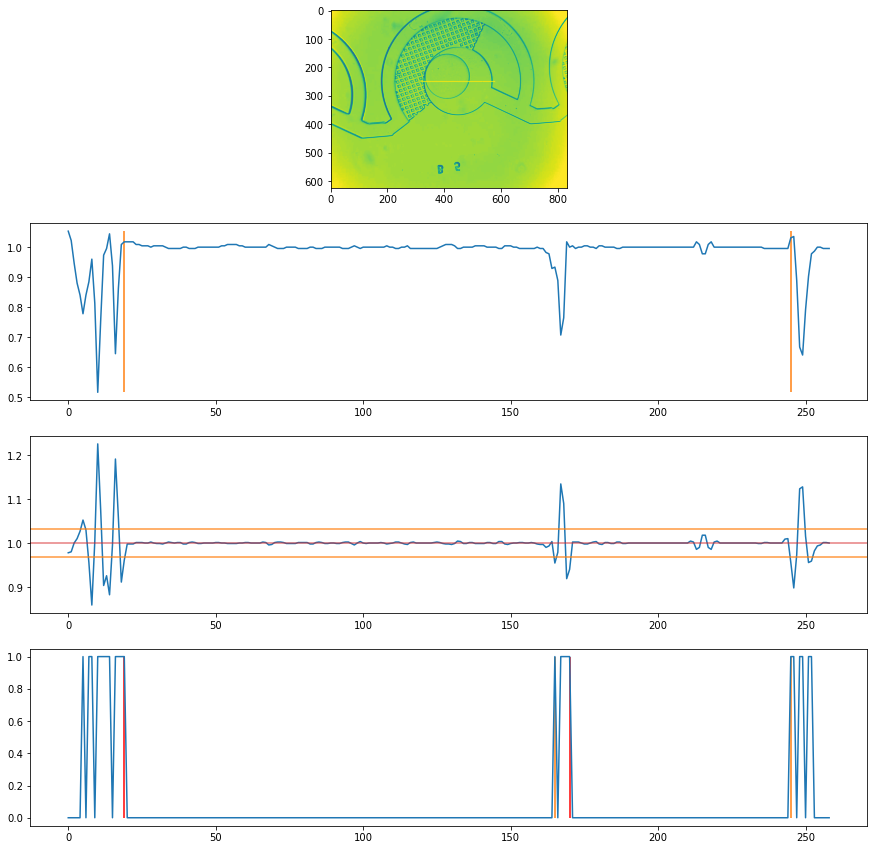

In [294]:
## profile plot test
array = np.array([[0,0,0,0,0],
                 [0,2,3,9,0],
                 [0,1,10,8,0],
                 [0,7,4,6,0],
                 [0,0,0,0,0]])


t = 0
c = 2
w = 0


img = time_resolution[t][c][w]['gray'].copy()
x = time_resolution[0][c][w]['circles'][0,0,0]
y = time_resolution[0][c][w]['circles'][0,0,1]
r = time_resolution[0][c][w]['circles'][0,0,2]

f = 1.1
L = int(x-f*r)
R = int(x+f*r)

row = img[y][L:R]
l = np.arange(row.size)


img_wL = cv2.line(img.copy(), (L,y), (R,y), (255,0,0), 2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(15,15))
ax1.imshow(img_wL)

row_norm = row / np.median(row)
ax2.plot(l, row_norm)

ax3.plot(l, np.gradient(np.gradient(row / np.median(row)))+1)
derv = np.gradient(np.gradient(row / np.median(row)))+1
ax3.axhline(np.median(derv), color='tab:red', alpha=0.6)
ax3.axhline(np.median(derv) + np.std(derv), color='tab:orange', alpha=0.8)
ax3.axhline(np.median(derv) - np.std(derv), color='tab:orange', alpha=0.8)

outside_std = outside_std_dev(derv)
left_edge, right_edge, solns, solns_rev = find_edges(outside_std, search_length=20)
        

ax4.plot(l, outside_std)
ax4.vlines(solns,0,1,color='red')
ax4.vlines(solns_rev,0,1,color="tab:orange")
ax2.vlines(left_edge, ymin=np.min(row_norm), ymax=np.max(row_norm), color="tab:orange")
ax2.vlines(right_edge, ymin=np.min(row_norm), ymax=np.max(row_norm), color="tab:orange")

#ax2.set_ylim([0, 1.2])
print(x,y,r)


In [293]:
## test of circle detection istead contour detection



temp = cv2.blur(time_resolution[t][conc_nr][well_nr]['masked image'].copy(), (2,2))

final = temp.copy()

minradius = int(time_resolution[0][conc_nr][well_nr]['circles'][0,0,2]*0.4)
maxradius = int(time_resolution[0][conc_nr][well_nr]['circles'][0,0,2]*0.97)

second_circles = cv2.HoughCircles(final,
                               cv2.HOUGH_GRADIENT, dp=1.1, minDist=150, param1=50, param2=40, minRadius=minradius, maxRadius=maxradius) 

# Draw

c_img = time_resolution[t][conc_nr][well_nr]['gray'].copy()

if second_circles is not None:
    second_circles = np.uint16(np.around(second_circles))
    
    
    for i in second_circles[0, :]:
        if i.any() > 1:
            print("penis")
        print(i)
        center = (i[0], i[1])
        radius = (i[2])
                
        cv2.circle(c_img, center, radius, (0, 0, 0), 2)
    
else:
    print("Penis")
    plt.imshow(time_resolution[t][conc_nr][well_nr]['gray'])
    
fig, ax = plt.subplots(figsize=(8, 5))
ax.imshow(c_img, cmap='gray')

conc_nr=2
well_nr=0
t=5


KeyError: 'masked image'

Well found:  True
Droplet found:  True
LLPS found:  True
file name:  t6_well3_4
 
initial concentrations:
BSA  PEG
[[228.           1.42857143]
 [180.5          3.21428571]
 [133.           5.        ]
 [ 85.5          6.78571429]
 [ 38.           8.57142857]]
 
LLPS concentrations:
BSA - conc.: 59.613 µM
PEG - conc.: 2.241 %
 
Areas: 19606   43743
List of Means
[2.4951298701298703, 2.265151515151515]


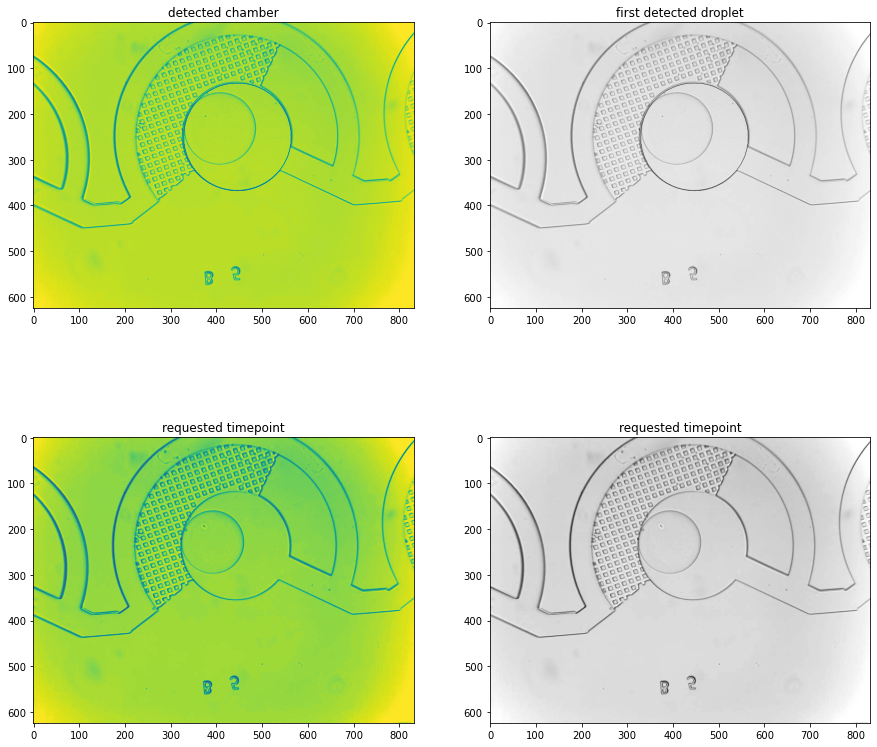

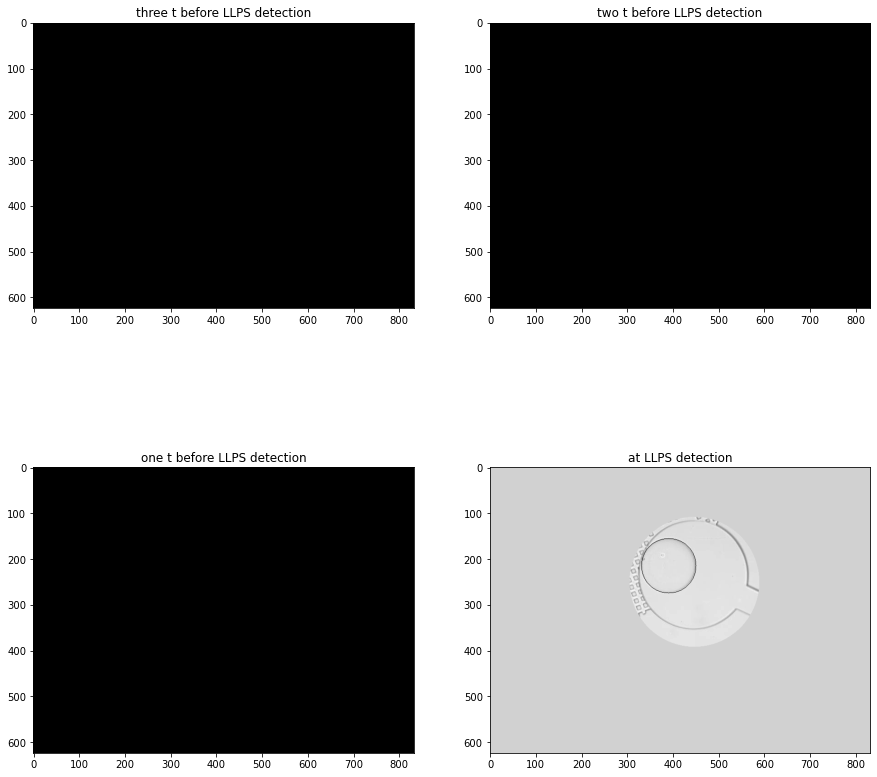

In [282]:
## ADJUSTED FOR HOUGH CIRCLES


def quality_control(bigdict, time_idx, conc_nr, well_nr, name_sol1, name_sol2, unit_sol1, unit_sol2,
                    starting_concentrations, circles):
    # Status
    print("Well found: ", bigdict[0][conc_nr][well_nr]['well found'])
    print("Droplet found: ", bigdict[0][conc_nr][well_nr]['detected droplet'])
    print("LLPS found: ", bigdict[0][conc_nr][well_nr]['LLPS status'])
    if bigdict[0][conc_nr][well_nr]['well found'] is True \
            and bigdict[0][conc_nr][well_nr]['LLPS status'] is True:
        print("file name: ", bigdict[0][conc_nr][well_nr]['LLPS name'])
    print(" ")
    print('initial concentrations:')
    print(name_sol1, '', name_sol2)
    print(starting_concentrations)

    # concentrations and areas
    if bigdict[0][conc_nr][well_nr]['well found'] is True \
            and bigdict[0][conc_nr][well_nr]['LLPS status'] is True:
        print(' ')
        print('LLPS concentrations:')
        print(f"{name_sol1}", f"- conc.: {round((bigdict[0][conc_nr][well_nr]['LLPS conc'][0, 0]), 3)} {unit_sol1}")
        print(f"{name_sol2}", f"- conc.: {round((bigdict[0][conc_nr][well_nr]['LLPS conc'][0, 1]), 3)} {unit_sol2}")
        print(" ")
        print("Areas:", int(bigdict[0][conc_nr][well_nr]['areas'][0, 0]), " ",
              int(bigdict[0][conc_nr][well_nr]['areas'][0, 1]))

    # Check which image can be displayed, all un-displayable images will be black (else blocks)
    
    gray_img = bigdict[time_idx][conc_nr][well_nr]['gray'].copy()

    if bigdict[0][conc_nr][well_nr]['well found'] is True:
        if bigdict[0][conc_nr][well_nr]['circles'] is not None:
            circles_img = bigdict[0][conc_nr][well_nr]['gray'].copy()
            circles = bigdict[0][conc_nr][well_nr]['circles']

            for i in circles[0, :]:
                center = (i[0], i[1])
                # circle outline
                radius = (i[2])
                cv2.circle(circles_img, center, radius, (0, 0, 0), 1)

        else:
            print("a")
            #circles_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
            
    if bigdict[0][conc_nr][well_nr]['detected droplet'] is True:
        droplet_info = bigdict[0][conc_nr][well_nr]['droplet information']
        droplet_img = bigdict[0][conc_nr][well_nr]['gray'].copy()
        
        for i in droplet_info[0, :]:
            center = (i[0], i[1])
            # circle outline
            radius = (i[2])
            cv2.circle(droplet_img, center, radius, (0, 0, 0), 1)
                
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 14)) 
    ax1.imshow(circles_img)
    ax1.set_title("detected chamber")
    ax2.imshow(droplet_img, cmap='gray')
    ax2.set_title("first detected droplet")
    ax3.imshow(bigdict[time_idx][conc_nr][well_nr]['gray'].copy())
    ax3.set_title("requested timepoint")
    ax4.imshow(bigdict[time_idx][conc_nr][well_nr]['gray'].copy(), cmap='gray')
    ax4.set_title("requested timepoint")


    
   
    


    print("List of Means")
    print(bigdict[0][conc_nr][well_nr]['mean list'])

    if bigdict[0][conc_nr][well_nr]['well found'] is True \
            and bigdict[0][conc_nr][well_nr]['LLPS status'] is True:

        fig2, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(15, 15))        
        
        if time_idx >= 6:
            ID = ((bigdict[0][conc_nr][well_nr]['ID']) - 3)
            A_10 = bigdict[ID][conc_nr][well_nr]['masked image'].copy()
            x = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,0]
            y = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,1]
            r = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,2]
            cv2.circle(A_10, (x, y), r, (0,0,0), 1)
        else:
            A_10 = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        
        if time_idx >= 5:
            ID = ((bigdict[0][conc_nr][well_nr]['ID']) - 2)
            A_11 = bigdict[ID][conc_nr][well_nr]['masked image'].copy()
            x = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,0]
            y = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,1]
            r = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,2]
            cv2.circle(A_11, (x, y), r, (0,0,0), 1)
        else:
            A_11 = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        
        if time_idx >= 4:
            ID = ((bigdict[0][conc_nr][well_nr]['ID']) - 1)
            A_12 = bigdict[ID][conc_nr][well_nr]['masked image'].copy()
            x = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,0]
            y = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,1]
            r = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,2]
            cv2.circle(A_12, (x, y), r, (0,0,0), 1)
        else:
            A_12 = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        
        # at LLPS detection
        if time_idx >= 3:
            ID = ((bigdict[0][conc_nr][well_nr]['ID']))
            grimes = bigdict[ID][conc_nr][well_nr]['masked image'].copy()
            x = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,0]
            y = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,1]
            r = bigdict[ID][conc_nr][well_nr]['droplet information'][0, 0 ,2]
            cv2.circle(grimes, (x, y), r, (0,0,0), 1)
        else:
            grimes = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)

        ax11.imshow(A_10, cmap='gray')
        ax11.set_title('three t before LLPS detection')
        ax12.imshow(A_11, cmap='gray')
        ax12.set_title('two t before LLPS detection')
        ax13.imshow(A_12, cmap='gray')
        ax13.set_title('one t before LLPS detection')
        ax14.imshow(grimes, cmap='gray')
        ax14.set_title('at LLPS detection')

        
        
time_idx = 3
conc_nr = 2
well_nr = 0

quality_control(time_resolution, time_idx, conc_nr, well_nr, name_sol1, name_sol2, 
                unit_sol1, unit_sol2, starting_concentrations, time_resolution[0][conc_nr][well_nr]['circles'])

In [ ]:
print(time_resolution[4][1][0]['droplet information'][0,0,2])
print(time_resolution[6][0][0]['droplet information'][0,0,2])

In [ ]:
ID = 3
A_10 = time_resolution[ID][conc_nr][well_nr]['masked image'].copy()
x = time_resolution[ID][conc_nr][well_nr]['droplet information'][0, 0 ,0]
y = time_resolution[ID][conc_nr][well_nr]['droplet information'][0, 0 ,1]
r = time_resolution[ID][conc_nr][well_nr]['droplet information'][0, 0 ,2]
cv2.circle(A_10, (x, y), r, (0,0,0), 1)

plt.imshow(A_10)

In [ ]:
## brightness controll test

import cv2

def BrightnessContrast(brightness=0):
	
	# getTrackbarPos returns the current
	# position of the specified trackbar.
	brightness = cv2.getTrackbarPos('Brightness',
									'GEEK')
	
	contrast = cv2.getTrackbarPos('Contrast',
								'GEEK')

	effect = controller(img, brightness,
						contrast)

	# The function imshow displays an image
	# in the specified window
	cv2.imshow('Effect', effect)

def controller(img, brightness=255,
			contrast=127):
	
	brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))

	contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))

	if brightness != 0:

		if brightness > 0:

			shadow = brightness

			max = 255

		else:

			shadow = 0
			max = 255 + brightness

		al_pha = (max - shadow) / 255
		ga_mma = shadow

		# The function addWeighted calculates
		# the weighted sum of two arrays
		cal = cv2.addWeighted(img, al_pha,
							img, 0, ga_mma)

	else:
		cal = img

	if contrast != 0:
		Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
		Gamma = 127 * (1 - Alpha)

		# The function addWeighted calculates
		# the weighted sum of two arrays
		cal = cv2.addWeighted(cal, Alpha,
							cal, 0, Gamma)

	# putText renders the specified text string in the image.
	cv2.putText(cal, 'B:{},_____C:{}'.format(brightness,
										contrast), (10, 30),
				cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

	return cal

if __name__ == '__main__':
	# The function imread loads an image
	# from the specified file and returns it.
	original = time_resolution[6][1][0]['gray'].copy()

	# Making another copy of an image.
	img = original.copy()

	# The function namedWindow creates a
	# window that can be used as a placeholder
	# for images.
	cv2.namedWindow('GEEK')

	# The function imshow displays an
	# image in the specified window.
	cv2.imshow('GEEK', original)

	# createTrackbar(trackbarName,
	# windowName, value, count, onChange)
	# Brightness range -255 to 255
	cv2.createTrackbar('Brightness',
					'GEEK', 255, 2 * 255,
					BrightnessContrast)
	
	# Contrast range -127 to 127
	cv2.createTrackbar('Contrast', 'GEEK',
					127, 2 * 127,
					BrightnessContrast)

	
	BrightnessContrast(0)

# The function waitKey waits for
# a key event infinitely or for delay
# milliseconds, when it is positive.
cv2.waitKey(0)


In [ ]:
def quality_control(bigdict, time_idx, conc_nr, well_nr, name_sol1, name_sol2, unit_sol1, unit_sol2,
                    starting_concentrations, circles):
    # Status
    print("Well found: ", bigdict[0][conc_nr][well_nr]['well found'])
    print("Droplet found: ", bigdict[0][conc_nr][well_nr]['detected droplet'])
    print("LLPS found: ", bigdict[0][conc_nr][well_nr]['LLPS status'])
    if bigdict[0][conc_nr][well_nr]['well found'] is True \
            and bigdict[0][conc_nr][well_nr]['LLPS status'] is True:
        print("file name: ", bigdict[0][conc_nr][well_nr]['LLPS name'])
    print(" ")
    print('initial concentrations:')
    print(name_sol1, '', name_sol2)
    print(starting_concentrations)

    # concentrations and areas
    if bigdict[0][conc_nr][well_nr]['well found'] is True \
            and bigdict[0][conc_nr][well_nr]['LLPS status'] is True:
        print(' ')
        print('LLPS concentrations:')
        print(f"{name_sol1}", f"- conc.: {round((bigdict[0][conc_nr][well_nr]['LLPS conc'][0, 0]), 3)} {unit_sol1}")
        print(f"{name_sol2}", f"- conc.: {round((bigdict[0][conc_nr][well_nr]['LLPS conc'][0, 1]), 3)} {unit_sol2}")
        print(" ")
        print("Areas:", int(bigdict[0][conc_nr][well_nr]['areas'][0, 0]), " ",
              int(bigdict[0][conc_nr][well_nr]['areas'][0, 1]))

    # Check which image can be displayed, all un-displayable images will be black (else blocks)
    # raw_img = bigdict[time_idx][conc_nr][well_nr]['raw'].copy()
    gray_img = bigdict[time_idx][conc_nr][well_nr]['gray'].copy()

    if circles is not None:
        for i in circles[0, :]:
            center = (i[0], i[1])
            # circle outline
            radius = (i[2])
            circles_img = cv2.circle(bigdict[0][conc_nr][well_nr]['gray'].copy(), center, radius, (0, 0, 0), 1)
    else:
        circles_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)

    if bigdict[0][conc_nr][well_nr]['well found'] is True:
        threshed_img = bigdict[time_idx][conc_nr][well_nr]['thresh']
        mopped_up_img = bigdict[time_idx][conc_nr][well_nr]['dilateanderode']
        dilated_img = bigdict[time_idx][conc_nr][well_nr]['dilate']

        allcontours_img = cv2.drawContours(bigdict[time_idx][conc_nr][well_nr]['gray'].copy(),
                                           bigdict[time_idx][conc_nr][well_nr]['contours'], -1, (255, 165, 0), 2)
       
        if bigdict[0][conc_nr][well_nr]['detected droplet'] is True:
            selectedcontours_img = cv2.drawContours(bigdict[time_idx][conc_nr][well_nr]['gray'].copy(),
                                                    bigdict[time_idx][conc_nr][well_nr]['contours droplet'], -1, (255, 165, 0), 2)

            if time_idx > 0:
                subtracted_img = bigdict[time_idx][conc_nr][well_nr]['subtracted']
                squircle_img = bigdict[time_idx][conc_nr][well_nr]['pixel values']
            else:
                subtracted_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
                squircle_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)

    else:
        threshed_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        mopped_up_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        dilated_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        allcontours_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        selectedcontours_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        subtracted_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)
        squircle_img = np.zeros(shape=bigdict[0][conc_nr][well_nr]['raw'].shape)

    # set up graph in figure
    x = range(len(bigdict[0][conc_nr][well_nr]['mean list']))
    y = bigdict[0][conc_nr][well_nr]['mean list']

    # plot everything
    fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15, 30))
    ax1.imshow(gray_img, cmap='gray')
    ax1.set_title('gray')
    ax2.imshow(circles_img, cmap='gray')
    ax2.set_title('found circles')
    ax3.imshow(threshed_img, cmap='binary')
    ax3.set_title('threshed')
    ax4.imshow(mopped_up_img, cmap='binary')
    ax4.set_title('after mop-up')
    ax5.imshow(dilated_img, cmap='binary')
    ax5.set_title('dilated')
    ax6.imshow(allcontours_img, cmap='gray')
    ax6.set_title('all detected contours')
    ax7.imshow(selectedcontours_img, cmap='gray')
    ax7.set_title('selected contours')
    ax8.imshow(subtracted_img , cmap='gray')
    ax8.set_title('subtraction result')
    ax9.imshow(squircle_img)
    ax9.set_title('squircle result')
    ax10.imshow(squircle_img)
    ax10.set_title('houghtest')
    
    fig1.savefig("penisfile.png", dpi=600)

    


    print("List of Means")
    print(bigdict[0][conc_nr][well_nr]['mean list'])

    if bigdict[0][conc_nr][well_nr]['well found'] is True \
            and bigdict[0][conc_nr][well_nr]['LLPS status'] is True:

        fig2, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(15, 15))        # before LLPS detections
        A_10 = bigdict[((bigdict[0][conc_nr][well_nr]['ID']) - 3)][conc_nr][well_nr]['masked image'].copy()
        A_11 = bigdict[((bigdict[0][conc_nr][well_nr]['ID']) - 2)][conc_nr][well_nr]['masked image'].copy()
        A_12 = bigdict[((bigdict[0][conc_nr][well_nr]['ID']) - 1)][conc_nr][well_nr]['masked image'].copy()
        # at LLPS detection
        grimes = bigdict[(bigdict[0][conc_nr][well_nr]['ID'])][conc_nr][well_nr]['masked image'].copy()

        ax11.imshow(A_10, cmap='gray')
        ax11.set_title('three t before LLPS detection')
        ax12.imshow(A_11, cmap='gray')
        ax12.set_title('two t before LLPS detection')
        ax13.imshow(A_12, cmap='gray')
        ax13.set_title('one t before LLPS detection')
        ax14.imshow(grimes, cmap='gray')
        ax14.set_title('at LLPS detection')


In [ ]:
## time to check
time_idx = 4


# concentration to check
conc_nr = 2

# well to check
well_nr = 0


# uncomment this to get some insight into image processing
quality_control(time_resolution, time_idx, conc_nr, well_nr, name_sol1, name_sol2,
                     unit_sol1, unit_sol2, starting_concentrations, time_resolution[0][conc_nr][well_nr]['circles'])

## Plot the data

In [ ]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol2} [{unit_sol2}]")
ax1.set_ylabel(f"{name_sol1} [{unit_sol1}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = 15
ylim = 50
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(5))
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0

for conc_nr in range (number_of_diff_conc):
    for n_rows_per_conc in range(2):
        for n_wells_per_row in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['well found'] is True and time_resolution[0][conc_nr][well_nr]['LLPS status'] is True:
            
                if conc_nr == 0:
                    color = "blue"
                if conc_nr == 1:
                    color = "orange"
                if conc_nr == 2:
                    color = "gray"
                if conc_nr == 3:
                    color = "yellow"
                if conc_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")
                ax1.scatter(time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1],time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0],
                            s=60, color=color, marker="o", edgecolors="black")
                
            well_nr += 1
    well_nr = 0
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for conc_nr in range (number_of_diff_conc):
    for n_rows_per_conc in range(2):
        for n_wells_per_row in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['well found'] is True and time_resolution[0][conc_nr][well_nr]['LLPS status'] is True:           
                # calculate mean
                mean_sol1[conc_nr] = mean_sol1[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0]
                mean_sol2[conc_nr] = mean_sol2[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[conc_nr] += 1
                
            well_nr += 1
    well_nr = 0
well_nr = 0


for conc_nr in range(number_of_diff_conc):
    if conc_nr == 0:
        color = "blue"
    if conc_nr == 1:
        color = "orange"
    if conc_nr == 2:
        color = "gray"
    if conc_nr == 3:
        color = "yellow"
    if conc_nr == 4:
        color = "green"
    if n_llps_wells[conc_nr] > 0:
        mean_sol1[conc_nr] = mean_sol1[conc_nr]/n_llps_wells[conc_nr]
        mean_sol2[conc_nr] = mean_sol2[conc_nr]/n_llps_wells[conc_nr]
        m = mean_sol1[conc_nr]/mean_sol2[conc_nr]
        
    ax2.plot([0, mean_sol2[conc_nr],xlim], [0, mean_sol1[conc_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol2[conc_nr],mean_sol1[conc_nr], s=60, color=color,
                           marker="o", edgecolors="black")
 